<a href="https://colab.research.google.com/github/enmwmak/EIE4122/blob/main/Gradient_vanishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab file demonstrates the gradient vanishing problem and how ResNet can overcome the problem.

Some of the codes in this Colab file are based on the examples in https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/



In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Create a working folder and cd to it.
!mkdir -p /content/drive/MyDrive/Learning/EIE4122/lab3
%cd /content/drive/MyDrive/Learning/EIE4122/lab3

Mounted at /content/drive
/content/drive/MyDrive/Learning/EIE4122/lab3


In [2]:
# Import packages
from sklearn.datasets import make_circles, make_moons
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.optimizer_v2.gradient_descent import SGD
from keras.layers import Dense
from keras.models import Sequential
from keras.initializers import RandomUniform
from keras.callbacks import TensorBoard


In [3]:
# Create two 2D spirals  
import numpy as np
def twospirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [4]:
# generate 2d classification dataset
#X, y = make_circles(n_samples=500, noise=0.1, random_state=1)
X, y = twospirals(500, noise=1.5)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

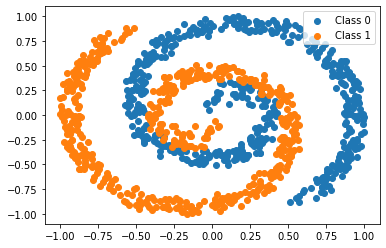

In [5]:
# Plot the two classes using two different colors
from matplotlib import pyplot
for i in range(2):
  idx = (y == i)
  pyplot.scatter(X[idx, 0], X[idx, 1], label=f"Class {str(i)}")
pyplot.legend()
pyplot.show()

In [6]:
# Split into train and test, shuffle the data
from sklearn.utils import shuffle
n_train = y.shape[0]//2
X, y = shuffle(X, y)
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

In [7]:
# Define and compile a feedforward net, using 'tanh' as non-linear activation function
act = 'tanh'
ffnet = Sequential()
ffnet.add(Dense(5, input_dim=2, activation=act, name='Input'))
l = 1
for i in range(30):
  ffnet.add(Dense(5, input_dim=5, activation=act, name=f'L{l}'))
  l = l + 1
ffnet.add(Dense(1, activation='sigmoid', name='Output'))
opt = SGD(learning_rate=0.01, momentum=0.9)
ffnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#ffnet.summary()
ffnet_init_weights = ffnet.get_weights()
print(f"No. of layers = {len(ffnet.layers)}")

No. of layers = 32


In [8]:
# Train the feedforward net without Tensorboard
ffnet_hist = ffnet.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

Train: 0.516, Test: 0.484


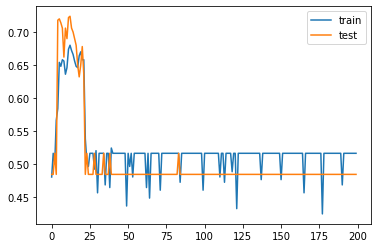

In [9]:
# Evaluate the ffnet and plot training/test accuracy against epoch
_, train_acc = ffnet.evaluate(trainX, trainy, verbose=0)
_, test_acc = ffnet.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(ffnet_hist.history['accuracy'], label='train')
pyplot.plot(ffnet_hist.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
# Define a ResNet, using 'tanh' as non-linear act function
import tensorflow as tf
from keras.layers import Add
act = 'tanh'
x_in = tf.keras.layers.Input((2), name='Input')
x = Dense(5, input_dim=2, activation=act, name='L1')(x_in)
x = Dense(5, input_dim=5, activation=act, name='L2')(x)
l = 3
for i in range(20):
  x_skip = x
  x = Dense(5, input_dim=5, activation=act, name=f'L{l}')(x)
  x = Dense(5, input_dim=5, activation=act, name=f'L{l+1}')(x)
  x = Add()([x, x_skip])
  l = l + 2
x = Dense(5, input_dim=5, activation=act, name=f'L{l}')(x)
x_out = Dense(1, activation='sigmoid', name='Output')(x)
resnet = tf.keras.models.Model(inputs=x_in, outputs=x_out, name="ResNet")
opt = SGD(learning_rate=0.01, momentum=0.9)
resnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#resnet.summary()
resnet_init_weights = resnet.get_weights()
print(f"No. of layers = {len(resnet.layers)}")

No. of layers = 65


In [11]:
# Train the resnet without Tensorboard
resnet_hist = resnet.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

Train: 0.968, Test: 0.962


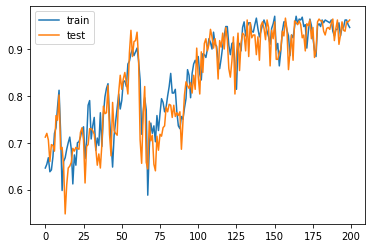

In [12]:
# Evaluate the resnet and plot training/test accuracy against epoch
_, train_acc = resnet.evaluate(trainX, trainy, verbose=0)
_, test_acc = resnet.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(resnet_hist.history['accuracy'], label='train')
pyplot.plot(resnet_hist.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [31]:
import tensorflow as tf

# keep track of the gradients over tensorboard for Tensorflow 2.X
bce = tf.keras.losses.BinaryCrossentropy()
class ExtendedTensorBoard(tf.keras.callbacks.TensorBoard):

  def _log_gradients(self, epoch):
    step = tf.cast(epoch, dtype=tf.int64)
    writer = self._train_writer

    with writer.as_default(), tf.GradientTape() as g:
      y_pred = self.model(trainX)
      y_true = np.asarray(trainy).astype('float32').reshape((-1,1))
      loss = bce(y_true=y_true, y_pred=y_pred)
      gradients = g.gradient(loss, self.model.trainable_weights)  # back-propagation

      # In eager mode, grads does not have name, so we get names from model.trainable_weights
      for weights, grads in zip(self.model.trainable_weights, gradients):
        tf.summary.histogram(
            weights.name.replace(':', '_')+'_grads', data=grads, step=step)

    writer.flush()

  def on_epoch_end(self, epoch, logs=None):  
  # def on_train_batch_end(self, batch, logs=None):  
    # This function overwrites the on_epoch_end in tf.keras.callbacks.TensorBoard
    # but we do need to run the original on_epoch_end, so here we use the super function. 
    super(ExtendedTensorBoard, self).on_epoch_end(epoch, logs=logs)
    # super(ExtendedTensorBoard, self).on_train_batch_end(batch, logs=logs)
    if self.histogram_freq and epoch % self.histogram_freq == 0:
      self._log_gradients(epoch)

In [14]:
!rm -rf ./logs/ffnet       # Remove logs in previous run

In [27]:
# Train the ffnet and use TensorBoard callback to log training info
ffnet_tb = ExtendedTensorBoard(log_dir='./logs/ffnet', histogram_freq=1) # you may change the file name to store info for different models
ffnet.set_weights(ffnet_init_weights)
ffnet.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0, callbacks=[ffnet_tb])

Inspect the **HISTOGRAM** in the TensorBoard to see how the weights in the bottom layers were changed during the training. In the histograms, the x-axis is the weight values, the y-axis is the epoch number, and the z-axis is the frequency of occurrences of the weight values.

In [ ]:
# Use Tensorboard to inspect the training info and gradients
%reload_ext tensorboard
%tensorboard --logdir='./logs/ffnet/'

In [32]:
!rm -rf ./logs/resnet       # Remove logs in previous run

In [33]:
# Train the resent and use TensorBoard callback to log training info
resnet_tb = ExtendedTensorBoard(log_dir='./logs/resnet', histogram_freq=1)
resnet.set_weights(resnet_init_weights)
resnet.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0, callbacks=[resnet_tb])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Use Tensorboard to inspect the training info and gradients
%reload_ext tensorboard
%tensorboard --logdir='./logs/resnet/'

**You may do the following:**

1.   Change the number of layers in *ffnet* to find the maximum number of layers that a feedforward network could have without suffering from gradient vanishing.
2.   Change the number of layers in *resnet* to find the maximum number of layers that a residue network could have without suffering from gradient vanishing.
3.   Change the 'tanh' to 'relu' and repeat (1) and (2) to see if ReLU could help mitigating the gradient vanishing problem.

**Your report should contain the following**
1.   The screen capture of the histograms of the weights at the bottom and the upper layers.
2.   The structure of the ResNet (you may infer this from the code or use *resnet.summary()*.
3.   Explanation of why the ResNet can be very deep but still does not suffer from the gradient vanishing problem.
4.   Explain why ReLU can help mitigating the gradient vanishing problem.

